## Load Packages

In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=8NHjlQBULk3TvI6eCqPzPrDs4IhnqigmPstLMazF6dM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWi6K7ED1IoBxq0j9RDUVRj3MXlFHEsZ2cpM9ePcZSwsrOL_QvBNoQc

Successfully saved authorization token.


In [2]:
!pip install wxee
!pip install rioxarray 
import os
from glob import glob
import wxee
import xarray as xr
import rioxarray as rio

     |████████████████████████████████| 43 kB 809 kB/s 
     |████████████████████████████████| 19.3 MB 5.0 MB/s 
     |████████████████████████████████| 25.3 MB 1.6 MB/s 
  Created wheel for wxee: filename=wxee-0.3.2-py3-none-any.whl size=37659 sha256=7c93400bd4d91293f99d3c047d901f00737c6bff33c1326ba77a33533b2df8fd
  Stored in directory: /root/.cache/pip/wheels/f3/a0/2b/ec90e21df9629000667e2df89982eb16b2af9d8a34370a7c3c
Successfully built wxee
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 46 kB 1.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 7.4 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.8.0-py3-none-any.whl size=54247 sha256=e3da70f45eda0816e6155a8acb1d15e3d443bac65a47d5436f2c51272c4cf11c
  St

## Processing in GEE

### Client-side Functions

In [3]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [4]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [5]:
# Function of Otsu's Method
def thresholding(image):
  
  waterIndex = index

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  histogram = image.select([index]).reduceRegion(
      reducer = ee.Reducer.histogram(255,2).combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      bestEffort = True)
  
  threshold = otsu(histogram.get(index+'_histogram'))
  water = image.select([index]).lt(threshold)
  return water.rename(['watermask']) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [6]:
# Function to Visualize
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
print('Folium version: ' + folium.__version__)


# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.8.3


### Define ROI

In [20]:
# Thailand
roi = ee.Geometry.Polygon(
        [[99.18087250062585, 9.293202617724758],
          [99.18087250062585, 9.161172665389476],
          [99.32404941152667, 9.161172665389476],
          [99.32404941152667, 9.293202617724758]], None, False)
# Vietnam
#roi = ee.Geometry.Polygon(
#    [[106.78004287743515, 20.141486311357436],
#     [106.78004287743515, 21.60942331713715],
#     [108.00327879982069, 21.60942331713715],
#     [108.00327879982069, 20.141486311357436]], None, False)
roi.getInfo()

{'coordinates': [[[99.18087250062585, 9.161172665389476],
   [99.32404941152667, 9.161172665389476],
   [99.32404941152667, 9.293202617724758],
   [99.18087250062585, 9.293202617724758],
   [99.18087250062585, 9.161172665389476]]],
 'geodesic': False,
 'type': 'Polygon'}

### Load Data

In [21]:
# Load Satellitie Archive
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
        .filterBounds(roi).sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)

ls_all = ls8.merge(ls7).merge(ls5).merge(ls4) \
        .sort('system:time_start', True)
print(ls_all.size().getInfo())        

640


### Mask Clouds

In [22]:
ls_cloudless = ls_all.map(maskCloud)
print(ls_cloudless.size().getInfo())

640


### Reduce by Year

In [23]:
years = ee.List.sequence(1984, 2019)
ls_Treduced = ee.ImageCollection.fromImages(
    years.map(lambda YEAR: ls_cloudless.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
                          .median() \
                          .clip(roi) \
                          .set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))
print(ls_Treduced.size().getInfo())

36


### Filter out years where no data available

In [24]:
# Add "bandlength" as new property
ls_filtered = ls_Treduced.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
ls_filtered = ls_filtered.filterMetadata('bandlength', 'not_equals', 0)
print(ls_filtered.size().getInfo())

33


In [25]:
list_A = ls_filtered.toList(ls_filtered.size())
image_A = ee.Image(list_A.get(-1)).clip(roi)
falseColor_id = image_A.getMapId({'min': 0, 'max': 2550,
                           'bands':['nir', 'red', 'green']})

centroid = roi.bounds().getInfo()['coordinates'][0][0]
centroid = [centroid[1], centroid[0]]

Mapdisplay(centroid, {'False Color Composite':falseColor_id}, zoom_start=12)

### Water Segmentation with Otsu

In [26]:
index = 'nir'
ls_wmsk = ls_filtered.map(thresholding)
print(ls_wmsk.size().getInfo())

33


In [27]:
list_B = ls_wmsk.toList(ls_wmsk.size())
image_B = ee.Image(list_B.get(-1)).clip(roi)
image_B = image_B.mask(image_B)
watermask_id = image_B.getMapId({'palette':'blue'})

Mapdisplay(centroid, {'False Color Composite':falseColor_id,
                      'Water Mask': watermask_id}, zoom_start=11)

### Clip to ROI

In [28]:
ls_clipped = ls_wmsk.map(lambda image: image.clip(roi))
print(ls_clipped.size().getInfo())

33


In [16]:
#ls_clipped.first().getInfo()

### Export to Drive

In [17]:
#img_clipped = ls_clipped.toBands()#.clip(roi)
#print(img_clipped.getInfo())

In [18]:
#task_config = {
#    'description': 'test_otsu',
#    'fileNamePrefix': 'test_otsu_big',
#    'crs': 'EPSG:4326',
#    'scale': 30,  
#    'region': roi.getInfo()['coordinates'],
#    'folder': 'myExportImage',
#    'skipEmptyTiles': True,
#    'fileFormat': 'GeoTIFF',
#    'maxPixels': 10e12
#    }
#task = ee.batch.Export.image.toDrive(img_clipped, **task_config)
#task.start() 

In [19]:
#task.status()

## Processing in Python

In [ ]:
#import pandas as pd

### Process GeoTiff in Xarray

In [35]:
#wdir = '/content/drive/My Drive/myExportImage/'
#path_images = glob(os.path.join(wdir,'*.tif'))
#path_images

In [36]:
#xda = rio.open_rasterio(path_images[-1])
#xda

In [37]:
#xda.attrs['long_name'][0].split('_')[0]
#imgID = [i.split('_')[0] for i in xda.attrs['long_name']]
#print(imgID)

In [38]:
#keys = [str(i) for i in range(36)]
#years = pd.date_range(start='1984', end='2020', freq='Y')
#pair = dict([[i,j] for i,j in zip(keys, years)])
#pair

In [39]:
#{key:pair[key] for key in imgID}

In [40]:
#xds = xda.to_dataset(name='watermask')
#xds

In [41]:
#xds.watermask.plot(robust=True, col="band", col_wrap=3)

### Transfer to xarray using wxee

In [29]:
# Export Image using wxee
#xdr = ls_clipped.wx.to_xarray(path='/content/drive/My Drive/myExportImage/test_otsu.nc', scale=30)

In [30]:
wdir = '/content/drive/My Drive/myExportImage/'
path_images = glob(os.path.join(wdir,'*.nc'))
path_images

['/content/drive/My Drive/myExportImage/test_otsu.nc']

In [31]:
xda = rio.open_rasterio(path_images[0])
xda

<xarray.DataArray 'watermask' (time: 33, y: 491, x: 532)>
[8619996 values with dtype=float64]
Coordinates:
  * time         (time) object 1987-12-31 00:00:00 ... 2019-12-31 00:00:00
  * x            (x) float64 99.18 99.18 99.18 99.18 ... 99.32 99.32 99.32 99.32
  * y            (y) float64 9.293 9.293 9.293 9.292 ... 9.162 9.162 9.161 9.161
    spatial_ref  int64 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    crs:                     +init=epsg:4326
    is_tiled:                1
    nodatavals:              -32768
    offsets:                 0
    res:                     [0.00026949 0.00026949]
    ...                      ...
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

In [33]:
xds = xda.to_dataset(name='watermask')
xds

<xarray.Dataset>
Dimensions:      (time: 33, x: 532, y: 491)
Coordinates:
  * time         (time) object 1987-12-31 00:00:00 ... 2019-12-31 00:00:00
  * x            (x) float64 99.18 99.18 99.18 99.18 ... 99.32 99.32 99.32 99.32
  * y            (y) float64 9.293 9.293 9.293 9.292 ... 9.162 9.162 9.161 9.161
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) float64 ...

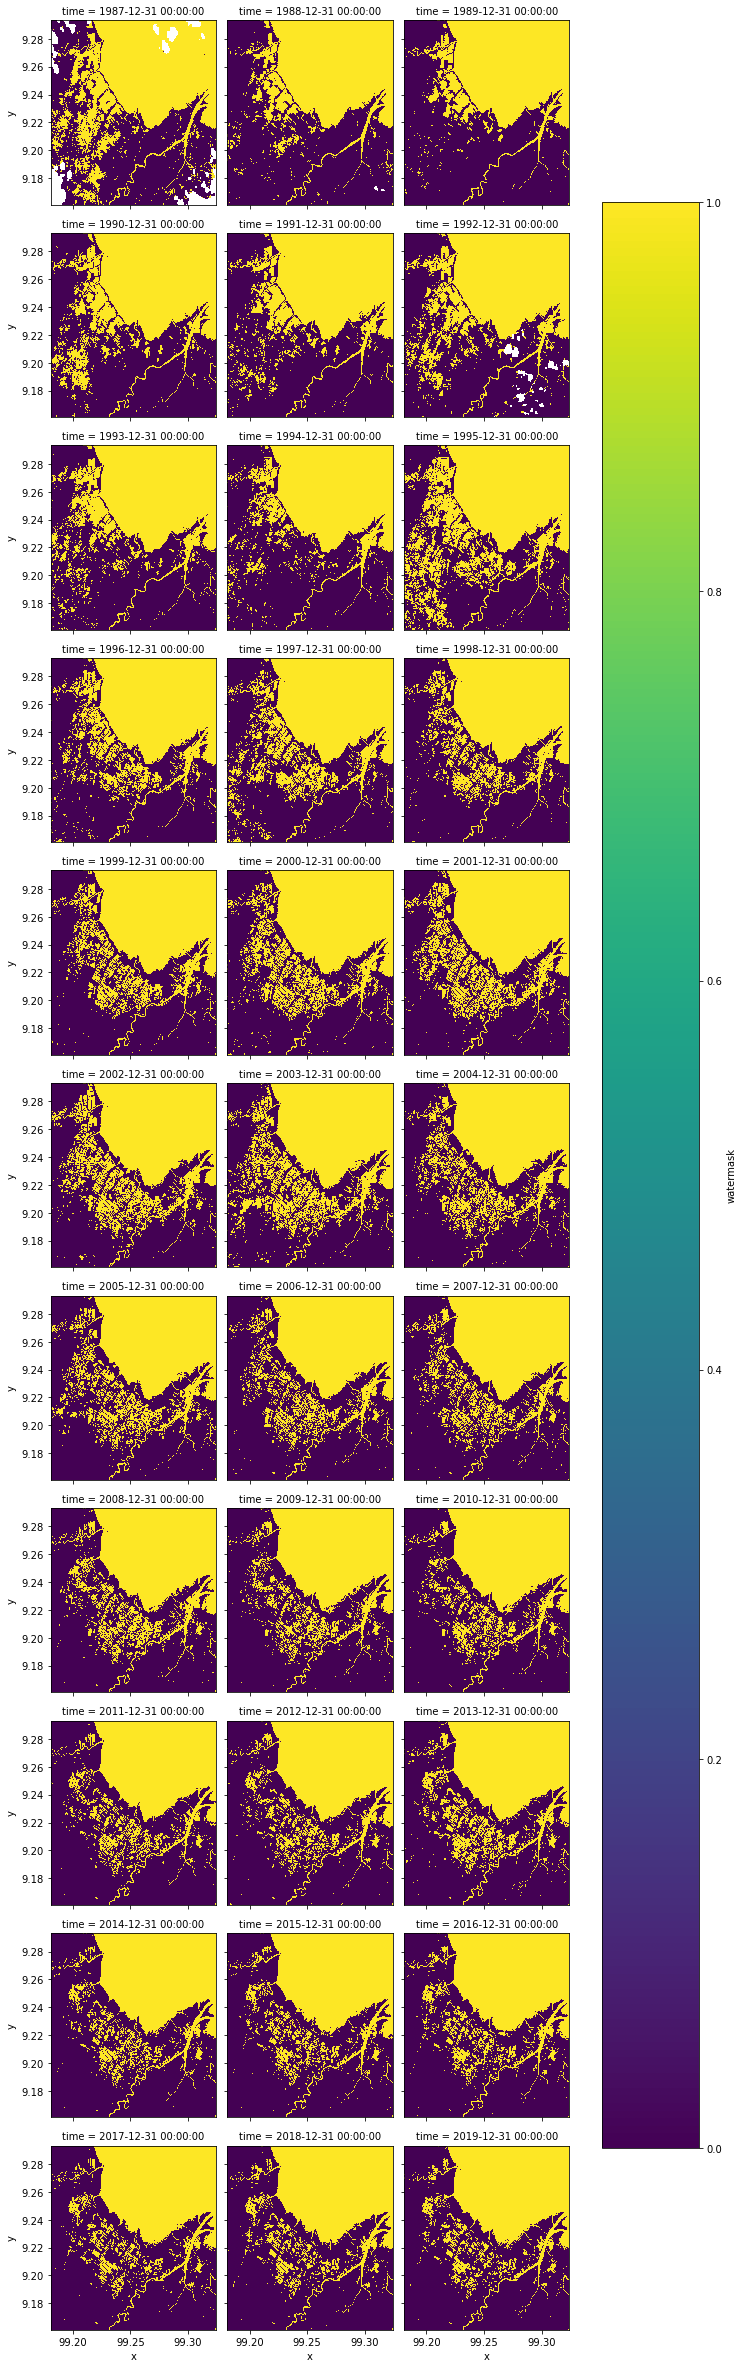

In [34]:
xds.watermask.plot(robust=True, col="time", col_wrap=3)